# SOLUTION NOTEBOOK

---

# MNIST multilayer network

## Exercise - Load and preprocess data

> **Exercise**: Load the MNIST data. Split it into train, validation and test sets. Standardize the images. Define a `get_batches(X, y, batch_size)` function to generate random X/y batches of size `batch_size` using a Python generator.

In [1]:
import numpy as np
import os

# Load data
with np.load(os.path.join('data', 'mnist-60k.npz'), allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
    
# Create train set
X_train, X_test, y_train, y_test = train_test_split(
    # Convert uint8 pixel values to float
    mnist['data'].astype(np.float32), mnist['labels'],
    test_size=2000, random_state=0)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=1000, random_state=0)

# Rescale input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (58000, 784) (58000,)
Valid: (1000, 784) (1000,)
Test: (1000, 784) (1000,)


In [3]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

## Exercise - Create and train a multilayer network

> **Exercise:** Create a multilayer neural network and train it using your batch generator. Evaluate the accuracy on the validation set after each epoch. Test different architectures and parameters. Evaluate your best network on the test set. Save the trained weights of the first fully connected layer in a variable.

In [4]:
import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 784])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    # Hidden layer with 64 units
    hidden = tf.layers.dense(
        X, 64, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    
    # Output layer
    logits = tf.layers.dense(
        hidden, 10, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    
    # Get weights of the first hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        
    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [5]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(15):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        # Get batches of data
        for X_batch, y_batch in get_batches(X_train, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.1 # Learning rate
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_test,
        y: y_test
    })
    print('Test accuracy: {:.3f}'.format(test_acc))
        
    # Weights of the hidden layer
    weights_hidden = W1.eval()

Epoch 1 - valid: 0.947 train: 0.918 (mean)
Epoch 2 - valid: 0.954 train: 0.958 (mean)
Epoch 3 - valid: 0.962 train: 0.970 (mean)
Epoch 4 - valid: 0.964 train: 0.975 (mean)
Epoch 5 - valid: 0.967 train: 0.980 (mean)
Epoch 6 - valid: 0.967 train: 0.984 (mean)
Epoch 7 - valid: 0.965 train: 0.987 (mean)
Epoch 8 - valid: 0.972 train: 0.989 (mean)
Epoch 9 - valid: 0.972 train: 0.991 (mean)
Epoch 10 - valid: 0.966 train: 0.993 (mean)
Epoch 11 - valid: 0.973 train: 0.994 (mean)
Epoch 12 - valid: 0.975 train: 0.996 (mean)
Epoch 13 - valid: 0.976 train: 0.997 (mean)
Epoch 14 - valid: 0.975 train: 0.997 (mean)
Epoch 15 - valid: 0.976 train: 0.998 (mean)
Test accuracy: 0.973


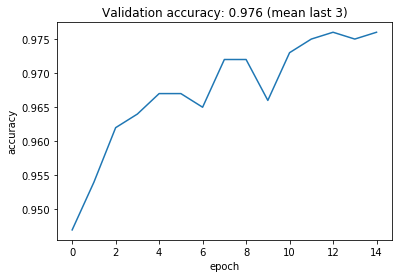

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:])
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Exercise - Visualize weights

> **Exercise**: Plot the weights from the first fully connected layer (the templates) with the `imshow()` function.

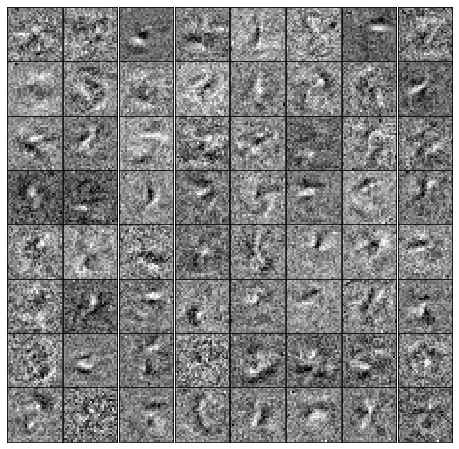

In [7]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the weights of the 64 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = weights_hidden[:, i]
    
    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)
    
    # Plot weights
    axis.imshow(weights, cmap=plt.cm.gray_r) # Grayscale
    axis.get_xaxis().set_visible(False) # Disable x-axis
    axis.get_yaxis().set_visible(False) # Disable y-axis
    
plt.show()

## With several graphs

In [ ]:
# Define graphs
simple_graph = tf.Graph()
complex_graph = tf.Graph()

with simple_graph.as_default():
    # ..

with complex_graph.as_default():
    # ..

# Use the graphs to run computations
with tf.Session(graph=simple_graph) as sess:
    # ..

with tf.Session(graph=complex_graph) as sess:
    # ..

# With grid search

In [8]:
for parameter in grid: # ----> loop over the hyperparameters

    # Create new graph
    tf.reset_default_graph()
    graph = tf.Graph()
    with graph.as_default():
       ...... # ----> Define all layers
       hidden = tf.layers.dense(X, units=parameter) # ----> set the hyerparameter
       ......

    # Start a session
    with tf.Session(graph=graph) as sess:
       ....

SyntaxError: invalid syntax (<ipython-input-8-604795ffc0a5>, line 7)